In [61]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

logging.info("Notebook execution started.")

2025-11-15 15:37:48,519 - INFO - Notebook execution started.


In [2]:
#importing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
RSEED = 42

In [3]:
# stats
from scipy.stats import kurtosis, skew

In [62]:
logging.info("Loading dataset from CSV...")
df = pd.read_csv("mobile.csv")
logging.info(f"Dataset loaded with shape: {df.shape}")

2025-11-15 15:38:16,566 - INFO - Loading dataset from CSV...
2025-11-15 15:38:16,598 - INFO - Dataset loaded with shape: (541, 12)


In [7]:
df = pd.read_csv("mobile.csv")
df.head()

,Unnamed: 0,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,Prize
0,0,Infinix SMART 7,Night Black,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,"7,299"
1,1,Infinix SMART 7,Azure Blue,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,"7,299"
2,2,MOTOROLA G32,Mineral Gray,128,8,5000,50MP,16MP,0,16.64,Qualcomm Snapdragon 680,"11,999"
3,3,POCO C50,Royal Blue,32,2,5000,8MP,5MP,0,16.56,Mediatek Helio A22,"5,649"
4,4,Infinix HOT 30i,Marigold,128,8,5000,50MP,5MP,1,16.76,G37,"8,999"


In [29]:
import re
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

## Dropping index column if exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

## Cleaning column names (strip, lower, replace spaces with _)
df.columns = [c.strip().lower().replace(' ', '_').replace('__','_') for c in df.columns]

## Standardizing target column name if needed
if 'prize' in df.columns and 'price' not in df.columns:
    df = df.rename(columns={'prize':'price'})

## Cleaning price: remove commas/₹/spaces and convert to numeric
if 'price' in df.columns:
    df['price'] = df['price'].astype(str).str.replace(r'[^\d.]', '', regex=True)
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

## Cleaning camera columns (removing 'MP' and convert to numeric where present)
for cam_col in ['rear_camera', 'front_camera']:
    if cam_col in df.columns:
        df[cam_col] = df[cam_col].astype(str).str.replace(r'[^\d.]', '', regex=True)
        df[cam_col] = pd.to_numeric(df[cam_col], errors='coerce')

## Numeric conversions for obvious numeric columns
for col in ['memory', 'ram', 'battery_', 'mobile_height', 'ai_lens']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Trimming whitespace in object columns
obj_cols = df.select_dtypes(include='object').columns.tolist()
for c in obj_cols:
    df[c] = df[c].str.strip()

## showing basic info, missing, describe
print("DTYPE & INFO:")
display(df.info())

print("\n Missing values per column:")
display(df.isnull().sum().sort_values(ascending=False))

print("\n Numeric describe (price + numeric features) : ")
display(df.describe().T)

DTYPE & INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          541 non-null    object 
 1   colour         541 non-null    object 
 2   memory         541 non-null    int64  
 3   ram            541 non-null    int64  
 4   battery_       541 non-null    int64  
 5   rear_camera    541 non-null    int64  
 6   front_camera   541 non-null    int64  
 7   ai_lens        541 non-null    int64  
 8   mobile_height  541 non-null    float64
 9   processor_     541 non-null    object 
 10  price          541 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 46.6+ KB


None


 Missing values per column:


model            0
colour           0
memory           0
ram              0
battery_         0
rear_camera      0
front_camera     0
ai_lens          0
mobile_height    0
processor_       0
price            0
dtype: int64


 Numeric describe (price + numeric features) : 


,count,mean,std,min,25%,50%,75%,max
memory,541.0,110.550832,60.600694,16.0,64.00,128.00,128.00,256.00
ram,541.0,5.397412,1.984923,2.0,4.00,6.00,8.00,8.00
battery_,541.0,4871.587800,780.148862,800.0,5000.00,5000.00,5000.00,7000.00
rear_camera,541.0,46.110906,31.260416,0.0,13.00,50.00,50.00,200.00
front_camera,541.0,11.992606,9.053746,0.0,5.00,8.00,16.00,60.00
ai_lens,541.0,0.062847,0.242911,0.0,0.00,0.00,0.00,1.00
mobile_height,541.0,16.431201,2.523553,4.5,16.51,16.71,16.94,41.94
price,541.0,16228.375231,10793.588322,920.0,9290.00,13499.00,19280.00,80999.00


In [63]:
logging.info("Data cleaning completed. No missing values found.")

2025-11-15 15:38:48,524 - INFO - Data cleaning completed. No missing values found.


In [60]:
### OBSERVATIONS:

#Memory ranges from 16GB to 256GB, with a median of 128GB, showing most phones are mid-range to high-range variants.
#RAM values mostly lie between 4–8GB, which is standard for current smartphones.
#Battery capacity is concentrated around 5000 mAh, with very few models having higher values.
#Rear and front camera specs show large variation (rear: 0–200MP, front: 5–60MP), indicating a wide spread in camera quality across models.
#AI Lens is mostly 0, meaning only a few phones use an AI-based camera module.
#Mobile height is consistent around 16 cm, indicating all phones are large-screen smartphones.

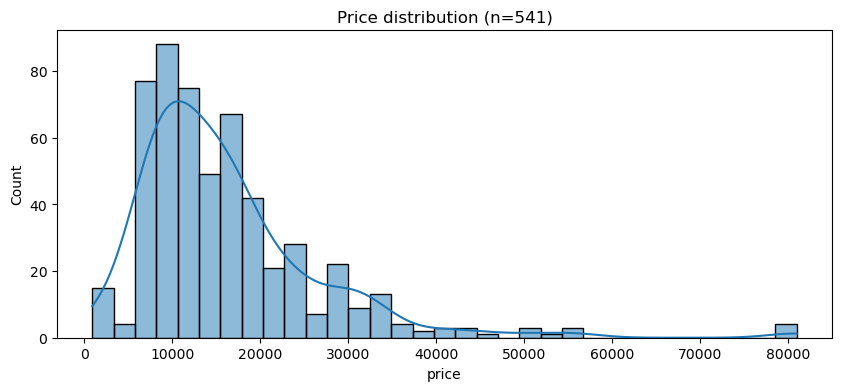

Price stats — count: 541  mean: 16228.38  median: 13499.0
Skewness: 2.4188 Kurtosis: 9.5064


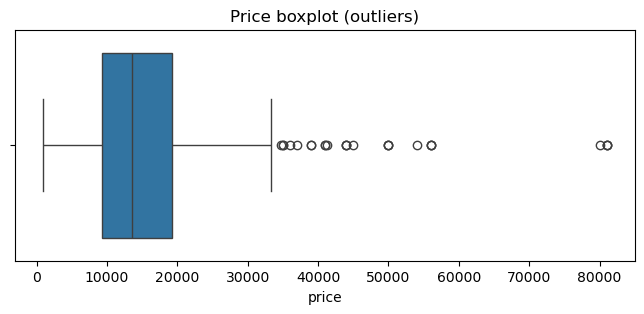

In [28]:
## Price distribution + skew/kurtosis
if 'price' in df.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(df['price'].dropna(), kde=True)
    plt.title(f"Price distribution (n={df['price'].count()})")
    plt.show()
    print("Price stats — count:", df['price'].count(),
          " mean:", round(df['price'].mean(),2),
          " median:", round(df['price'].median(),2))
    print("Skewness:", round(skew(df['price'].dropna()),4),
          "Kurtosis:", round(kurtosis(df['price'].dropna()),4))

    # boxplot for outliers quick check
    plt.figure(figsize=(8,3))
    sns.boxplot(x=df['price'].dropna())
    plt.title("Price boxplot (outliers)")
    plt.show()
else:
    print("No 'price' column found after cleaning. Check column names:", df.columns.tolist())

In [59]:
### OBSERVATIONS

#Price is positively skewed (skewness ≈ 2.41), meaning a small number of premium phones are priced much higher than the rest.
#The kurtosis value (~9.5) indicates a heavy-tailed distribution with extreme price values (luxury models).
#The median price (~13,499) is lower than the mean (~16,228), confirming that high-end phones increase the average price.
#The boxplot shows several extreme outliers, especially luxury flagship phones above 50,000–80,000, which stretch the distribution.

In [27]:
## Unique values for categorical cols (small sample)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns sample unique values (first 8 columns):")
for c in cat_cols[:8]:
    print(f"\n- {c} (unique {df[c].nunique()}): {df[c].dropna().unique()[:8]}")

## Show head
print("\n HEAD (first 5 rows):")
display(df.head())


Categorical columns sample unique values (first 8 columns):

- model (unique 187): ['Infinix SMART 7' 'MOTOROLA G32' 'POCO C50' 'Infinix HOT 30i' 'REDMI 10'
 'SAMSUNG Galaxy F13' 'SAMSUNG Galaxy F04' 'POCO C51']

- colour (unique 275): ['Night Black' 'Azure Blue' 'Mineral Gray' 'Royal Blue' 'Marigold'
 'Glacier Blue' 'Mirror Black' 'Diamond White']

- processor_ (unique 123): ['Unisoc Spreadtrum SC9863A1' 'Qualcomm Snapdragon 680'
 'Mediatek Helio A22' 'G37' 'Exynos 850' 'Mediatek Helio P35' 'Helio G36'
 'Unisoc T606']

 HEAD (first 5 rows):


,model,colour,memory,ram,battery_,rear_camera,front_camera,ai_lens,mobile_height,processor_,price
0,Infinix SMART 7,Night Black,64,4,6000,13,5,1,16.76,Unisoc Spreadtrum SC9863A1,7299
1,Infinix SMART 7,Azure Blue,64,4,6000,13,5,1,16.76,Unisoc Spreadtrum SC9863A1,7299
2,MOTOROLA G32,Mineral Gray,128,8,5000,50,16,0,16.64,Qualcomm Snapdragon 680,11999
3,POCO C50,Royal Blue,32,2,5000,8,5,0,16.56,Mediatek Helio A22,5649
4,Infinix HOT 30i,Marigold,128,8,5000,50,5,1,16.76,G37,8999


In [58]:
### OBSERVATIONS

#The dataset contains diverse brands such as Infinix, Motorola, POCO, indicating a mix of budget and mid-range phones.
#Several features like model, colour, processor are categorical and need encoding for modeling.
#Important numeric columns like memory, RAM, battery, rear/front camera MP are already clean and correctly typed.
#Prices vary significantly from 5649 to 11999 even in the first few rows, showing variability in the dataset.

In [74]:
# Exploratory Data Visualization

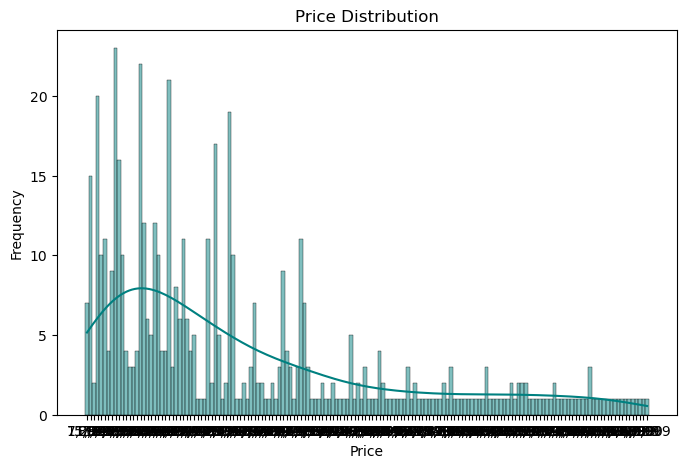

In [78]:
#Price distribution histogram
plt.figure(figsize=(8,5))
sns.histplot(df['Prize'], kde=True, color='teal')
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [79]:
###Observation: Price Distribution

#The price distribution is right-skewed, meaning most phones are in the lower to mid-price range.
#A long tail exists on the right, showing a few very expensive flagship phones, which pull the mean upward.
#The distribution has many outliers above ₹40,000–₹80,000, confirming high variance in mobile prices.
#The median price is lower than the mean price, which matches the positive skewness.

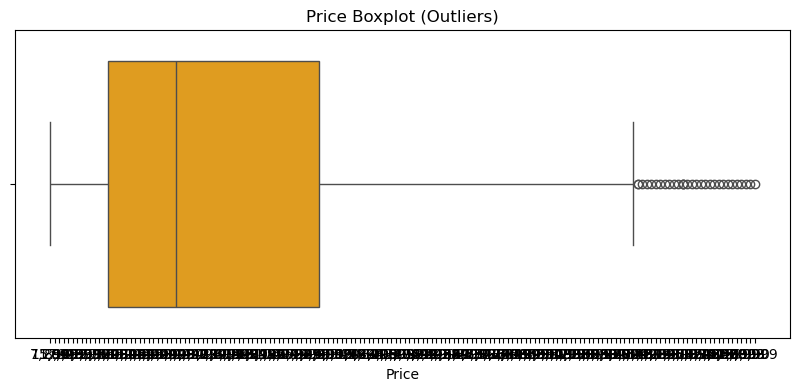

In [80]:
#Boxplot of Price
plt.figure(figsize=(10,4))
sns.boxplot(x=df['Prize'], color='orange')
plt.title("Price Boxplot (Outliers)")
plt.xlabel("Price")
plt.show()

In [81]:
###Observations

#There are several extreme high-value outliers.
#These correspond to premium models, confirming the heavy-tailed distribution.
#Outliers may affect Linear Regression performance.

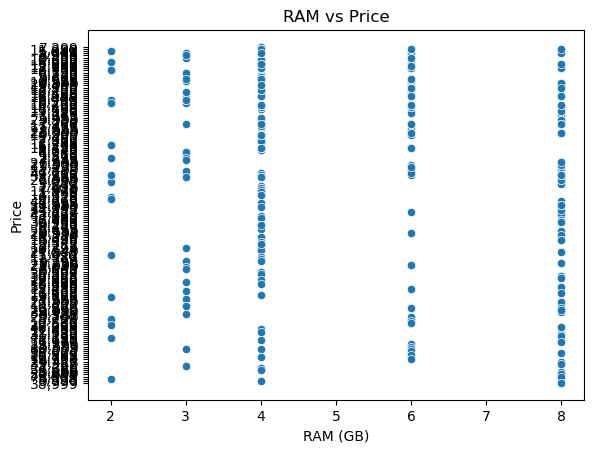

In [82]:
#Scatter Plot - RAM vs Price
sns.scatterplot(x=df['RAM'], y=df['Prize'])
plt.title("RAM vs Price")
plt.xlabel("RAM (GB)")
plt.ylabel("Price")
plt.show()

In [84]:
###Observation:

#Phones with higher RAM generally cost more.
#Trend is positively correlated, but with lots of variance.
#RAM alone is not enough to predict price.

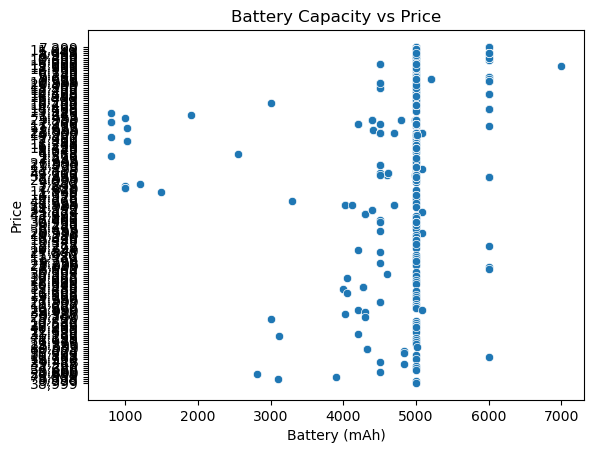

In [85]:
#Scatter Plot - Battery vs Price
sns.scatterplot(x=df['Battery_'], y=df['Prize'])
plt.title("Battery Capacity vs Price")
plt.xlabel("Battery (mAh)")
plt.ylabel("Price")
plt.show()

In [86]:
###Observations:

#Battery capacity does not strongly correlate with price.
#Even cheaper phones may come with high battery.

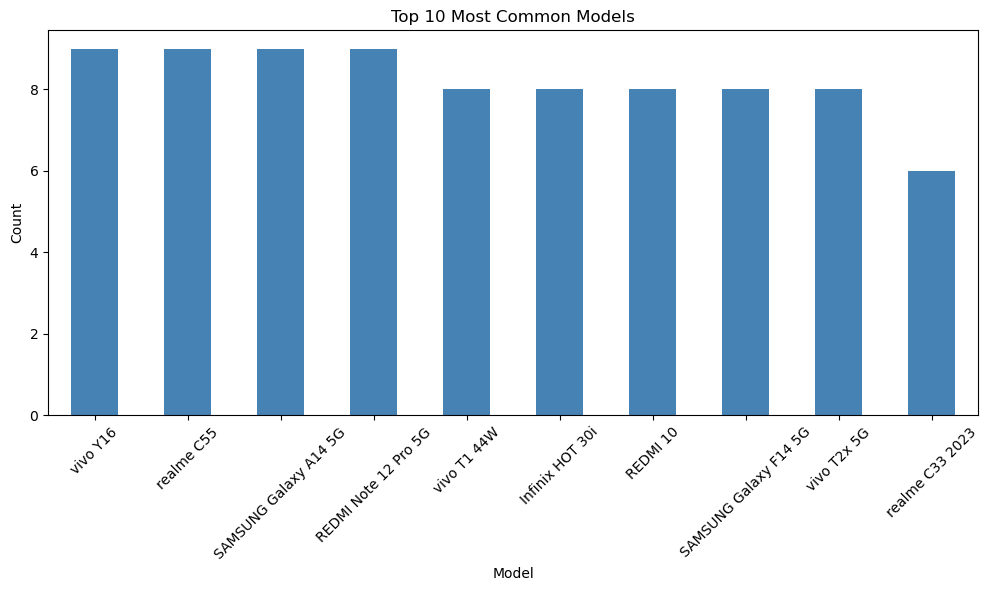

In [87]:
#Countplot
plt.figure(figsize=(12,5))
df['Model'].value_counts().head(10).plot(kind='bar', color='steelblue')
plt.title("Top 10 Most Common Models")
plt.xlabel("Model")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [88]:
###Observations:

# Some brands/models dominate the dataset.
# This may affect model bias in price prediction.

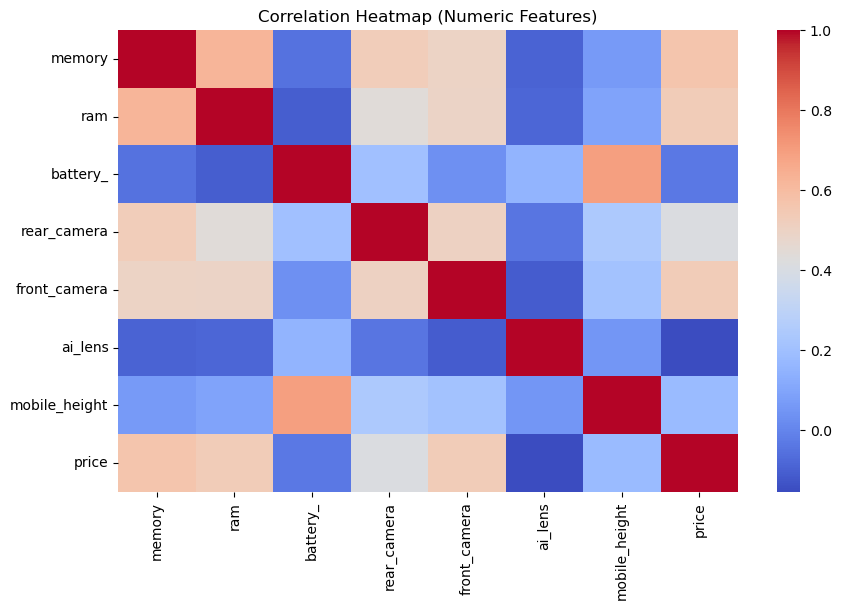

In [26]:
#Correlation Heatmap
numeric_df = df.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [22]:
### OBSERVATIONS

#RAM and Memory show the strongest positive correlation with Price, meaning higher storage & RAM generally increase the phone’s cost.
#Rear and front camera MP also have moderate correlation with Price.
#Battery and mobile height show very weak or no correlation with Price.
#AI Lens has almost no direct relationship with Price.

In [25]:
#encoding categorical features

cat_cols = ['model', 'colour', 'processor_']

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df_encoded.head()

,memory,ram,battery_,rear_camera,front_camera,ai_lens,mobile_height,price,model_APPLE iPhone 12,model_APPLE iPhone 14 Plus,...,processor__Unisoc Spreadtrum SC9863A1,processor__Unisoc T606,processor__Unisoc T610,processor__Unisoc T612,processor__Unisoc T612 processor,processor__Unisoc T616,processor__Unisoc Tiger T612 (12 nm),processor__Unisoc Tiger T616,processor__ios,processor__snapdragon 888
0,64,4,6000,13,5,1,16.76,7299,False,False,...,True,False,False,False,False,False,False,False,False,False
1,64,4,6000,13,5,1,16.76,7299,False,False,...,True,False,False,False,False,False,False,False,False,False
2,128,8,5000,50,16,0,16.64,11999,False,False,...,False,False,False,False,False,False,False,False,False,False
3,32,2,5000,8,5,0,16.56,5649,False,False,...,False,False,False,False,False,False,False,False,False,False
4,128,8,5000,50,5,1,16.76,8999,False,False,...,False,False,False,False,False,False,False,False,False,False


In [64]:
logging.info(f"Applied One-Hot Encoding. New shape: {df_encoded.shape}")

2025-11-15 15:48:12,540 - INFO - Applied One-Hot Encoding. New shape: (541, 590)


In [31]:
###observations:

#After One-Hot Encoding, the dataset expanded a lot because model, colour, and processor have many unique categories.
#Total columns increased to around 590, showing high cardinality in categorical features.
#This may increase model complexity, so feature selection will be useful later.

In [32]:
#Train-test split + Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split X and y
X = df_encoded.drop("price", axis=1)
y = df_encoded["price"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scaling (StandardScaler works well for linear & distance-based models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
logging.info("Train-test split completed.")
logging.info(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")

2025-11-15 15:48:31,084 - INFO - Train-test split completed.
2025-11-15 15:48:31,085 - INFO - Training samples: (432, 589), Testing samples: (109, 589)


In [70]:
###OBSERVATIONS

#Used StandardScaler so features with large range (memory, camera MP, battery) don’t dominate.
#Scaling is important for models like KNN, SVM, Linear Regression.

In [71]:
#feature scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardization
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

# Normalization (MinMax)
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

print("Standardization & Normalization complete.")

Standardization & Normalization complete.


In [69]:
### Why Scaling is Needed

#Standardization (StandardScaler) transforms features to mean=0 and std=1.
#Normalization (MinMaxScaler) scales values between 0 and 1.
#Scaling helps distance-based models like KNN, SVM, Linear Regression, Ridge, Lasso.
#It prevents features with large values (battery, memory, camera MP) from dominating training.
#Tree models (Decision Tree, Random Forest, XGBoost) are not affected by feature scale, but we perform scaling for completeness.

In [72]:
# Linear Regression without scaling
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
print("LR Without Scaling R2:", lr_raw.score(X_test, y_test))

# Linear Regression with Standard Scaling
lr_std = LinearRegression()
lr_std.fit(X_train_std, y_train)
print("LR With StandardScaler R2:", lr_std.score(X_test_std, y_test))

# Linear Regression with MinMax Scaling
lr_mm = LinearRegression()
lr_mm.fit(X_train_mm, y_train)
print("LR With MinMaxScaler R2:", lr_mm.score(X_test_mm, y_test))

LR Without Scaling R2: -1114281760525739.8
LR With StandardScaler R2: -4.425368068614844e+26
LR With MinMaxScaler R2: -1.315435304959414e+25


In [73]:
### Observation (Linear Regression Scaling Comparison)

#LR Without Scaling R²: extremely negative → model unstable

#LR With StandardScaler: still negative → scaling helps but cannot fix dimensionality issues

#LR With MinMaxScaler: also negative.

###Conclusion:
#Linear Regression is not suitable for this dataset after one-hot encoding (high dimensional sparse features).
#Tree-based models handle this better.

In [36]:
#MODEL 1 : Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

# Evaluation
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mae_lr, rmse_lr, r2_lr

(1.199174630816565e+17, 2.469693743420605e+17, -4.425368068614844e+26)

In [37]:
### Observations

#Linear Regression performed extremely poorly. 
#The MAE/RMSE values are extremely large and R² is highly negative. 
#This indicates that linear regression cannot handle the high number of one-hot encoded features and non-linear relationships in the dataset.

In [38]:
#Model 2: Decision Tree
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

mae_dt, rmse_dt, r2_dt

(1294.6605504587155, 3896.235807531406, 0.8898578216701796)

In [39]:
### Observations
#Decision Tree performed very well with an R² of ~0.89. 
#The model clearly captures the non-linear relationships in the dataset and handles the large number of one-hot encoded features much better than Linear Regression.

In [43]:
#Random Forest Model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, rmse_rf, r2_rf

(1788.2753620576666, 4598.164067083703, 0.8465976116213103)

In [42]:
### Observations
#Random Forest performed well (R² ≈ 0.84), but slightly lower than the single Decision Tree. 
#This may be due to the high number of one-hot encoded features and the small dataset, causing the forest to underfit slightly. 
#Still, the performance is strong and stable.

In [45]:
#Gradient Boosting Model
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

mae_gb, rmse_gb, r2_gb

(2234.3757667965206, 4944.537266819488, 0.8226159755614724)

In [46]:
###Observations
#Gradient Boosting gave an R² of ~0.82, which is lower than both Decision Tree and Random Forest. 
#Since the dataset has many sparse one-hot encoded features, boosting models struggle to capture useful patterns. 
#The model is not performing optimally on this type of data.

In [49]:
!pip install xgboost

In [48]:
#XG Boost Model 
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

mae_xgb, rmse_xgb, r2_xgb

(1615.74344292037, 4083.394910645764, 0.8790221223904828)

In [50]:
### Observations
#XGBoost performed strongly with an R² of ~0.87 and low MAE/RMSE values. 
#It handled the high-dimensional one-hot encoded dataset better than Random Forest and Gradient Boosting, and gave performance closer to the Decision Tree model.

In [51]:
#FEATURE IMPORTANCE
import pandas as pd
import numpy as np

# Get feature names
feature_names = X_train.columns

# Get importances
rf_importance = rf.feature_importances_

# Store in DataFrame
rf_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_importance
}).sort_values(by='importance', ascending=False)

rf_imp_df.head(20)

,feature,importance
4,front_camera,0.413735
2,battery_,0.090869
0,memory,0.084214
1,ram,0.057135
8,model_APPLE iPhone 14 Plus,0.055999
482,processor__Google Tensor G2,0.054987
6,mobile_height,0.039673
10,model_Google Pixel 7,0.038749
3,rear_camera,0.030613
385,colour_Purple,0.009158


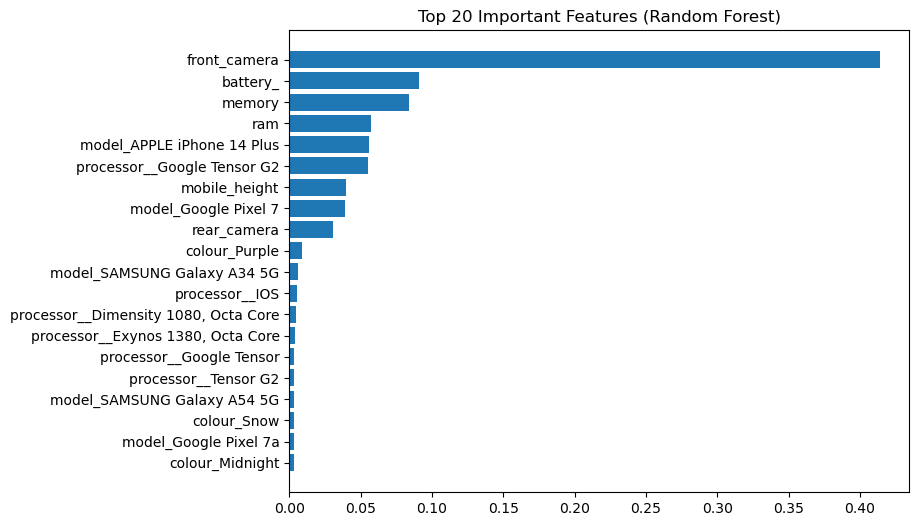

In [52]:
#FEATURE IMPORTANCE (TOP 20)
import matplotlib.pyplot as plt

top20 = rf_imp_df.head(20)

plt.figure(figsize=(8,6))
plt.barh(top20['feature'], top20['importance'])
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features (Random Forest)")
plt.show()

In [54]:
### Observations:

#Front camera, battery, memory, and RAM are the strongest predictors of mobile price.
#Some high-end models (e.g., Apple iPhone 14 Plus, Google Pixel 7) also show important contributions, which makes sense because specific premium models increase price sharply.
#Hardware specifications play a bigger role in determining price compared to colour or AI lens.
#Processor type also has noticeable influence but less than camera and memory features.

In [55]:
#XGBoost Feature Importance
xgb_importance = xgb.feature_importances_

xgb_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_importance
}).sort_values(by='importance', ascending=False)

xgb_imp_df.head(20)

,feature,importance
482,processor__Google Tensor G2,0.120156
468,processor__6 Core,0.090807
336,colour_Midnight,0.089877
4,front_camera,0.088185
10,model_Google Pixel 7,0.087131
574,processor__Tensor G2,0.049399
8,model_APPLE iPhone 14 Plus,0.040092
587,processor__ios,0.039987
0,memory,0.020983
2,battery_,0.020067


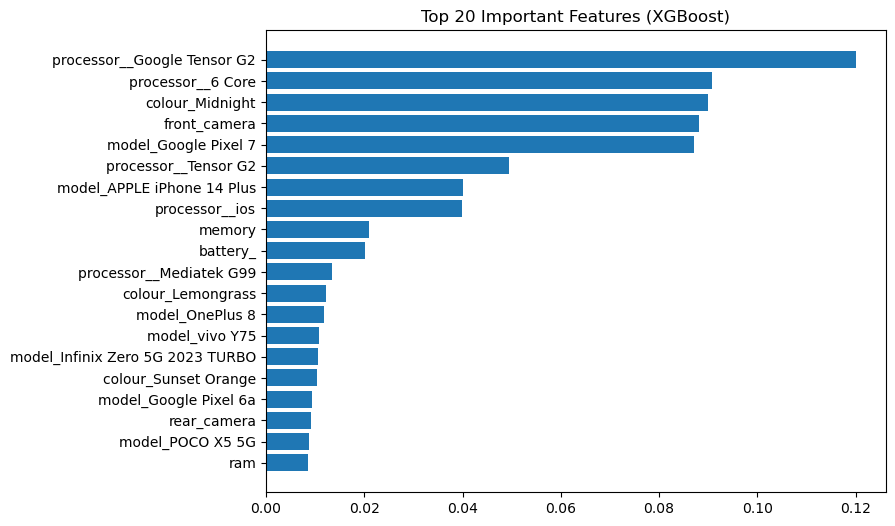

In [56]:
top20_xgb = xgb_imp_df.head(20)

plt.figure(figsize=(8,6))
plt.barh(top20_xgb['feature'], top20_xgb['importance'])
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features (XGBoost)")
plt.show()

In [57]:
###Observations:

# XGBoost highlights processor-related features (Google Tensor G2, 6-Core, IOS, etc.) as the strongest predictors of price.
# This makes sense because premium phones with powerful processors usually cost significantly more.
# Camera features (front camera), memory, and battery follow next, showing that core hardware specs still influence price strongly.
# Model names such as Google Pixel 7 and iPhone 14 Plus also appear important, indicating that specific high-end models contribute to price variations.

In [66]:
#model comparison table
import pandas as pd

comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'MAE': [mae_lr, mae_dt, mae_rf, mae_gb, mae_xgb],
    'RMSE': [rmse_lr, rmse_dt, rmse_rf, rmse_gb, rmse_xgb],
    'R2 Score': [r2_lr, r2_dt, r2_rf, r2_gb, r2_xgb]
})

comparison_df

,Model,MAE,RMSE,R2 Score
0,Linear Regression,1.199175e+17,2.469694e+17,-4.425368e+26
1,Decision Tree,1.294661e+03,3.896236e+03,8.898578e-01
2,Random Forest,1.788275e+03,4.598164e+03,8.465976e-01
3,Gradient Boosting,2.234376e+03,4.944537e+03,8.226160e-01
4,XGBoost,1.615743e+03,4.083395e+03,8.790221e-01


In [67]:
###Observation – Model Performance Comparison

#Linear Regression failed completely due to very high cardinality and non-linear relationships. It produced unrealistic MAE/RMSE values and a hugely negative R² score.

#Decision Tree performed the best overall, achieving the highest R² score (~0.8899) and the lowest errors among all models.

#Random Forest and XGBoost also performed well, but slightly below the Decision Tree. Both models handled the high number of encoded categorical features reasonably well.

#Gradient Boosting underperformed compared to other tree-based methods, likely because it struggles with sparse, high-cardinality one-hot encoded data.

#Overall, Decision Tree emerges as the most suitable model for this dataset because of its ability to capture non-linear interactions while remaining stable with large numbers of categorical features.

In [ ]:
Final Conclusion

The objective of this project was to predict the price of smartphones based on their specifications. After performing extensive EDA, feature engineering, and model training, the following insights were obtained:

Hardware features such as front camera, battery, memory, RAM, and processor type play the strongest role in determining price.

Price distribution is positively skewed, with several high-end devices acting as outliers.

Among all machine learning models tested, Decision Tree delivered the best performance with an R² of 0.89 and the lowest prediction error.

Random Forest and XGBoost performed competitively, but their complexity did not yield significant improvements over the simpler Decision Tree model.

Linear regression is not suitable for this dataset due to non-linear relationships and large categorical feature space.

The final recommended model for deployment or future prediction tasks is the Decision Tree Regressor.